In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import seaborn as sns
import corner as corner

In [2]:
%matplotlib notebook

In [3]:
def Ensure_all(All_variables):
    no_nan_tables = [table.dropna() for table in All_variables]
    
    num_variables = len(no_nan_tables)
    previous_merge = no_nan_tables[0]
    for index in range(1, num_variables):
        current_table = no_nan_tables[index]
        previous_merge = pd.merge(previous_merge, current_table, left_index=True, right_index=True, how='inner')
    return previous_merge

def PlanetRadiusErrors(Ratio, Radius, RatioError, RadiusError):
    Error = np.sqrt((Ratio*RadiusError)**2 + (Radius*RatioError)**2)*const.R_sun/const.R_earth
    return Error

In [4]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project'

Gaia_stars = pd.read_csv(f'{Main_directory}/Samples/Sorted Data/Stars/Gaia All Stars.csv', index_col='Gaia DR3 ID').dropna()
BASTA_stars = pd.read_csv(f'{Main_directory}/BASTA/Output/GaiaResultsFinal.ascii', index_col='starid' ,sep='\t').dropna()
Planet_data = pd.read_csv(f'{Main_directory}/Samples/Sorted Data/Planets/Final Planets.csv'
                          , index_col='KOI').dropna()

add_sys = True
if add_sys:
    Gaia_stars['Rad pe'] += 0.035*Gaia_stars['Radius']
    Gaia_stars['Rad me'] += 0.035*Gaia_stars['Radius']
    Gaia_stars['Teff pe'] = np.sqrt(Gaia_stars['Teff pe']**2 + 102**2)
    Gaia_stars['Teff me'] = np.sqrt(Gaia_stars['Teff me']**2 + 102**2)

#Pre BASTA
Planet_calc = Planet_data.set_index('Host Gaia DR3 ID')
Valley_data = Ensure_all([Gaia_stars[['Radius', 'Rad pe', 'Rad me']], Planet_calc])

Valley_data['Planet Radii'] = Valley_data['Radius']*Valley_data['PSR']*const.R_sun/const.R_earth
Valley_data['Planet Rad pe'] = PlanetRadiusErrors(Valley_data['PSR'], Valley_data['Radius']
                                                  , Valley_data['PSR pme'], Valley_data['Rad pe'])
Valley_data['Planet Rad me'] = PlanetRadiusErrors(Valley_data['PSR'], Valley_data['Radius']
                                                  , Valley_data['PSR pme'], Valley_data['Rad me'])
Valley_data.reset_index(inplace=True)
Valley_data = Valley_data.drop(Valley_data[Valley_data['Planet Radii'] > 4].index)


#Post BASTA
BASTA_Valley = Ensure_all([BASTA_stars[['radPhot', 'radPhot_errp', 'radPhot_errm']], Planet_calc])

BASTA_Valley['Planet Radii'] = BASTA_Valley['radPhot']*BASTA_Valley['PSR']*const.R_sun/const.R_earth
BASTA_Valley['Planet Rad pe'] = PlanetRadiusErrors(BASTA_Valley['PSR'], BASTA_Valley['radPhot']
                                                  , BASTA_Valley['PSR pme'], BASTA_Valley['radPhot_errp'])
BASTA_Valley['Planet Rad me'] = PlanetRadiusErrors(BASTA_Valley['PSR'], BASTA_Valley['radPhot']
                                                  , BASTA_Valley['PSR pme'], BASTA_Valley['radPhot_errm'])

BASTA_Valley.reset_index(inplace=True)
BASTA_Valley = BASTA_Valley.drop(BASTA_Valley[BASTA_Valley['Planet Radii'] > 4].index)

print(BASTA_stars)

                            Teff   Teff_errp   Teff_errm       FeH  FeH_errp  \
starid                                                                         
1044013542142711296  3688.182306   52.572741   40.117064 -0.049900  0.150000   
1074139748425931008  5350.155367   93.120084   83.139687  0.284911  0.094840   
1076970406751899008  6453.361330   87.698379   94.023913  0.003125  0.111523   
1111639314047794944  6063.465826   95.381136   86.028395 -0.040263  0.106970   
111322601672419712   5265.610561   49.299269   58.167389 -0.016058  0.121050   
...                          ...         ...         ...       ...       ...   
869913435026514688   4503.619997   37.387258   51.634914  0.439882  0.034067   
876608292608416512   5782.171858   99.756970  101.756617  0.100789  0.107857   
898130030131443584   6149.876372  106.692252  101.107841 -0.137991  0.118582   
920308932010648448   5394.845713  108.982963   88.238777  0.171417  0.121698   
990291507088739072   6211.542391   94.78

In [5]:
Gaia_stars.drop(columns=Gaia_stars.columns[7:], inplace=True)
Gaia_stars.dropna(inplace=True)

def LuminosityErrors(Radius, Teff, RadiusError, TeffError):
    Error = 2*Radius*Teff**3/5772**4*np.sqrt(Teff**2*RadiusError**2 + 4*Radius**2*TeffError**2)
    return Error

Gaia_stars['Luminosity'] = Gaia_stars['Radius']**2*(Gaia_stars['Teff']/5772)**4
Gaia_stars['Luminosity pe'] = LuminosityErrors(Gaia_stars['Radius'], Gaia_stars['Teff'], 
                                               Gaia_stars['Rad pe'], Gaia_stars['Teff pe'])
Gaia_stars['Luminosity me'] = LuminosityErrors(Gaia_stars['Radius'], Gaia_stars['Teff'], 
                                               Gaia_stars['Rad me'], Gaia_stars['Teff me'])

BASTA_stars['Luminosity'] = BASTA_stars['radPhot']**2*(BASTA_stars['Teff']/5772)**4
BASTA_stars['Luminosity pe'] = LuminosityErrors(BASTA_stars['radPhot'], BASTA_stars['Teff'], 
                                               BASTA_stars['radPhot_errp'], BASTA_stars['Teff_errp'])
BASTA_stars['Luminosity me'] = LuminosityErrors(BASTA_stars['radPhot'], BASTA_stars['Teff'], 
                                               BASTA_stars['radPhot_errm'], BASTA_stars['Teff_errm'])

<IPython.core.display.Javascript object>


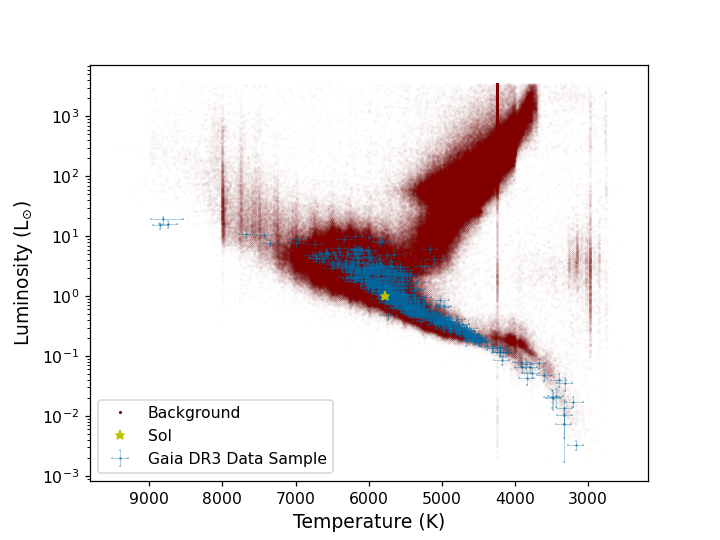

In [6]:
Colour = plt.style.use('tableau-colorblind10')

HR_data = pd.read_csv(f'{Main_directory}/Samples/Raw Data/HR Data (Flags).csv')

plt.figure()
plt.plot(6000, 1, '.', color='maroon', markersize=2, label='Background')
plt.plot(HR_data['teff_gspspec'], HR_data['lum_flame'], '.', color='maroon', markersize=0.1, alpha=0.3)
plt.errorbar(Gaia_stars['Teff'], Gaia_stars['Luminosity']
             , yerr=[Gaia_stars['Luminosity pe'], Gaia_stars['Luminosity me']]
             , xerr=[Gaia_stars['Teff pe'], Gaia_stars['Teff me']]
             , markersize=2, elinewidth=0.5, capsize=0.5, alpha=0.4 ,fmt='.', label='Gaia DR3 Data Sample')
plt.plot(5772, 1, 'y*', label='Sol', zorder=3)
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Luminosity (L$_{\odot}$)', fontsize=12)
#plt.title('Gaia DR3 Star Sample', fontsize=12)
plt.gca().invert_xaxis()
plt.legend()
#plt.savefig('Sample HR diagram')
plt.show()

<IPython.core.display.Javascript object>


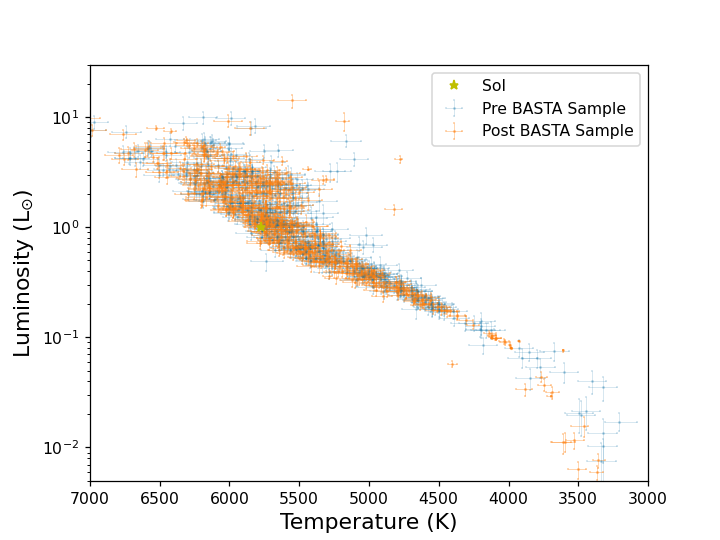

In [29]:
plt.figure()
#plt.plot(6000, 1, '.', color='maroon', markersize=2, label='Background')
#plt.plot(HR_data['teff_gspspec'], HR_data['lum_flame'], '.', color='maroon', markersize=0.1, alpha=0.3)
plt.errorbar(Gaia_stars['Teff'], Gaia_stars['Luminosity']
             , yerr=[Gaia_stars['Luminosity pe'], Gaia_stars['Luminosity me']]
             , xerr=[Gaia_stars['Teff pe'], Gaia_stars['Teff me']]
             , markersize=2, elinewidth=0.5, capsize=0.5, alpha=0.2 ,fmt='.', label='Pre BASTA Sample')
plt.errorbar(BASTA_stars['Teff'], BASTA_stars['Luminosity']
             , yerr=[BASTA_stars['Luminosity pe'], BASTA_stars['Luminosity me']]
             , xerr=[BASTA_stars['Teff_errp'], BASTA_stars['Teff_errm']]
             , markersize=2, elinewidth=0.5, capsize=0.5, alpha=0.4 ,fmt='.', label='Post BASTA Sample')
plt.plot(5772, 1, 'y*', label='Sol', zorder=3)
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('Luminosity (L$_{\odot}$)', fontsize=14)
#plt.title('Gaia DR3 Star Sample', fontsize=12)
plt.xlim(3000, 7000)
plt.ylim(0.005, 30)
plt.gca().invert_xaxis()
plt.legend()
plt.savefig('Sample HR diagram')
plt.show()

<IPython.core.display.Javascript object>


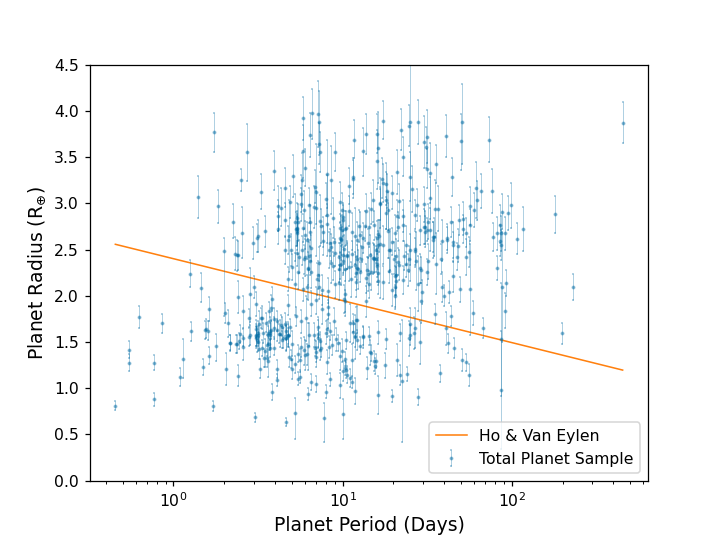

C:\Users\Iwan\AppData\Local\Temp\ipykernel_13768\685263826.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(Valley_data['P'], Valley_data['Planet Radii']


In [8]:
x = np.linspace(min(Valley_data['P']), max(Valley_data['P']), 2)
m = -0.11
c = 0.37
y = 10**(m*np.log10(x) + c)

plt.figure()
plt.errorbar(Valley_data['P'], Valley_data['Planet Radii']
             , yerr=[Valley_data['Planet Rad pe'], Valley_data['Planet Rad me']]
             , markersize=1.5, marker='o', elinewidth=0.5, capsize=0.5, alpha=0.4 ,fmt='.', label='Total Planet Sample')
plt.plot(x, y, linewidth=1, zorder=1, label='Ho & Van Eylen')
plt.ylim(0, 4.5)
plt.xscale('log')
plt.ylabel('Planet Radius (R$_{\oplus}$)', fontsize=12)
plt.xlabel('Planet Period (Days)', fontsize=12)
plt.legend()
#plt.savefig('Pre BASTA Radius Valley')
plt.show()

<IPython.core.display.Javascript object>


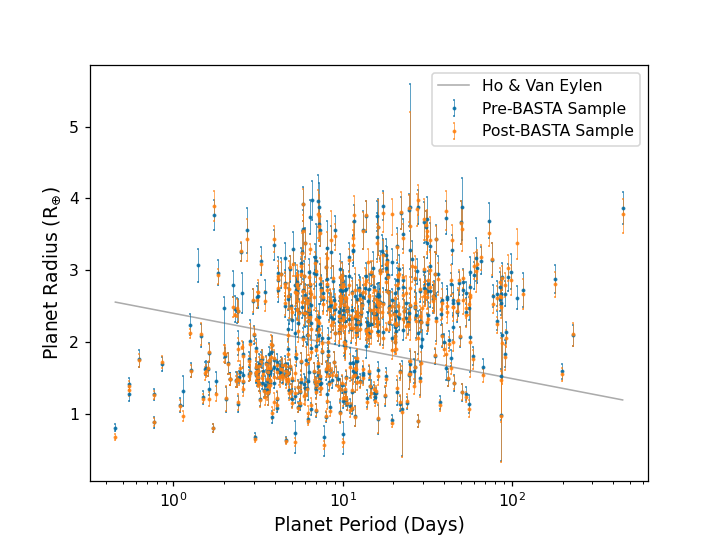

C:\Users\Iwan\AppData\Local\Temp\ipykernel_13768\1668156712.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(Valley_data['P'], Valley_data['Planet Radii']
C:\Users\Iwan\AppData\Local\Temp\ipykernel_13768\1668156712.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(BASTA_Valley['P'], BASTA_Valley['Planet Radii']


In [9]:
plt.figure()
plt.errorbar(Valley_data['P'], Valley_data['Planet Radii']
             , yerr=[Valley_data['Planet Rad pe'], Valley_data['Planet Rad me']]
             , markersize=1.5, marker='o', elinewidth=0.5, capsize=0.5, alpha=0.8 ,fmt='.', label='Pre-BASTA Sample')
plt.errorbar(BASTA_Valley['P'], BASTA_Valley['Planet Radii']
             , yerr=[BASTA_Valley['Planet Rad pe'], BASTA_Valley['Planet Rad me']]
             , markersize=1.5, marker='o', elinewidth=0.5, capsize=0.5, alpha=0.8 ,fmt='.', label='Post-BASTA Sample')
plt.plot(x, y, linewidth=1, zorder=1, label='Ho & Van Eylen')
#plt.ylim(0, 4.5)
plt.xscale('log')
plt.ylabel('Planet Radius (R$_{\oplus}$)', fontsize=12)
plt.xlabel('Planet Period (Days)', fontsize=12)
plt.legend()
plt.savefig('Pre BASTA Radius Valley')
plt.show()

<IPython.core.display.Javascript object>


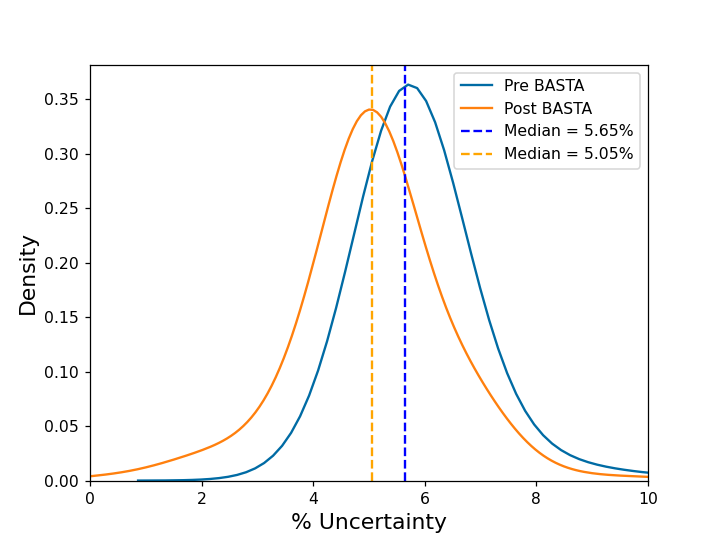

In [44]:
avg_unc0 = 50*(Gaia_stars['Rad pe'] + Gaia_stars['Rad me'])/Gaia_stars['Radius']
avg_unc1 = 50*(BASTA_stars['radPhot_errp'] + BASTA_stars['radPhot_errm'])/BASTA_stars['radPhot']

plt.figure()
ax = sns.kdeplot(data=avg_unc0, bw_adjust=2, label='Pre BASTA')
sns.kdeplot(data=avg_unc1, bw_adjust=2, label='Post BASTA')
plt.axvline(np.median(avg_unc0), linestyle='--', color='blue', label='Median = 5.65%')
plt.axvline(np.median(avg_unc1), linestyle='--', color='orange', label='Median = 5.05%')
plt.xlim(0, 10)
plt.xlabel('% Uncertainty', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.savefig('Uncertainty KDE')
plt.show()

6.842339668160884
6.368429934348461


<IPython.core.display.Javascript object>


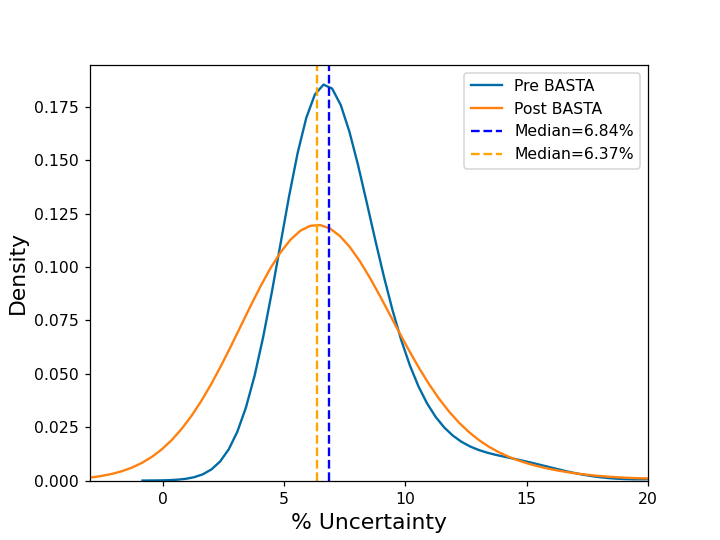

In [51]:
avg_unc0 = 50*(Valley_data['Planet Rad pe'] + Valley_data['Planet Rad pe'])/Valley_data['Planet Radii']
avg_unc1 = 50*(BASTA_Valley['Planet Rad pe'] + BASTA_Valley['Planet Rad me'])/BASTA_Valley['Planet Radii']

print(np.median(avg_unc0))
print(np.median(avg_unc1))

plt.figure()
ax = sns.kdeplot(data=avg_unc0, bw_adjust=1, label='Pre BASTA')
sns.kdeplot(data=avg_unc1, bw_adjust=2, label='Post BASTA')
plt.axvline(np.median(avg_unc0), linestyle='--', color='blue', label='Median=6.84%')
plt.axvline(np.median(avg_unc1), linestyle='--', color='orange', label='Median=6.37%')
plt.xlim(-3, 20)
plt.xlabel('% Uncertainty', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.savefig('Uncertainty KDE')
plt.show()